# 模型

本章我们将会讨论如何建立一个模型。首先我们会按前两章所述，简要的讲解一下数据读入和预处理。然后我们将讨论建模的过程，如超参数的选择，模型评估指标等，我们将着重讲述一些实践中的经验，不会深入讲解模型的算法等。

## 读取和预处理数据

### 读取数据

我们可以使用`pandas`库中的`read_excel`方法来读取数据。

In [1]:
# 读取数据

import pandas as pd

data = pd.read_excel('data/pfm_data.xlsx')
data.head()

,EmployeeNumber,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,Over18,OverTime,StandardHours,TotalWorkingYears,YearsAtCompany,Attrition
0,77,37,Travel_Rarely,Research & Development,1,4,Life Sciences,Male,3,5993,1,Y,No,80,7,7,0
1,1245,54,Travel_Frequently,Research & Development,1,4,Life Sciences,Female,3,10502,7,Y,No,80,33,5,0
2,147,34,Travel_Frequently,Research & Development,7,3,Life Sciences,Male,3,6074,1,Y,Yes,80,9,9,1
3,1026,39,Travel_Rarely,Research & Development,1,1,Life Sciences,Female,4,12742,1,Y,No,80,21,21,0
4,1111,28,Travel_Frequently,Research & Development,1,3,Medical,Male,2,2596,1,Y,No,80,1,1,1


### 切分数据集

接下来，我们将数据集切分为训练集与测试集。`scikit-learn`的`model_selection`模块中提供了`train_test_split`方法，我们可以通过`test_size`参数设置一个作为测试集数据的百分比，而`stratify`一般设置为`label`，可以设置按照这个`label`进行分层取样。

In [2]:
# 切分训练集和测试集

from sklearn.model_selection import train_test_split

x = data.drop(columns='Attrition')
y = data['Attrition']

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.25, stratify=y, random_state=1024)
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((825, 16), (275, 16), (825,), (275,))

### 预处理数据集

随后，我们按照上一章中的`Preprocessor`类来构造用于数据预处理的类。在这里，我们简化了部分方法，例如去掉了将变换器进行保存和读取的方法。

In [3]:
# 预处理数据类

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer


class Preprocessor:
    def __init__(self):
        # 待转为str类型的列
        self.to_str_cols = ['Education', 'JobSatisfaction']
        # id列
        self.id_col = 'EmployeeNumber'
        # 待去掉的列
        self.to_rm_cols = ['StandardHours', 'Over18']
        # 变换器
        self.column_transformer = None

    def remove_columns(self, data):
        """
        去掉可以删除的列
        :param data: 数据
        :return:
        """
        # 删除ID列
        data = data.drop(columns=self.id_col)
        # 删除StandardHours和Over18这两列
        data = data.drop(columns=self.to_rm_cols)

        return data

    def transform_train(self, train_data):
        """
        变换训练集
        :param train_data: 训练集
        :return:
        """
        # 数值类型的特征
        num_cols = train_data.select_dtypes(include=np.number).columns.tolist()
        # 去掉年龄特征
        num_cols.remove('Age')
        # 类别类型的特征
        cat_cols = train_data.select_dtypes(include=np.object).columns.tolist()

        self.column_transformer = ColumnTransformer(
            [
                # 对类别型数据做One-Hot编码
                ('one-hot', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                # 对除了数值类型做标准化
                ('scale', StandardScaler(), num_cols),
                # 对age字段做离散化，转化为5个类别
                ('discretizer', KBinsDiscretizer(n_bins=5), ['Age'])
            ]
        )

        return self.column_transformer.fit_transform(train_data)

    def transform_test(self, test_data):
        """
        变换测试集
        :param test_data: 测试集
        :return:
        """
        if self.column_transformer is None:
            print('column transformer is None!')
            return

        return self.column_transformer.transform(test_data)

    def preprocess_data(self, data, train_or_test=0):
        """
        预处理数据集
        :param data: 数据
        :param train_or_test: 训练或者测试：0 - 训练，1 - 测试
        :return:
        """
        data = self.remove_columns(data)
        if train_or_test == 0:
            return self.transform_train(data)
        return self.transform_test(data)

最后，我们初始化一个预处理示例，对训练集和测试集分别进行预处理。

In [4]:
preprocessor = Preprocessor()
train_x = preprocessor.preprocess_data(train_x)
test_x = preprocessor.preprocess_data(test_x, train_or_test=1)
train_x.shape, test_x.shape

((825, 28), (275, 28))

## 建模

### 如何选择模型

当我们着手开始建模型时，摆在我们面前的一个问题便是：我们应当选择哪个模型来建模呢？  
在一些场景下，例如数据模型竞赛，模型的准确率是一个非常重要的指标，甚至可以说是唯一的指标，因此相互比较多个模型的准确率，最后选择准确率最高的模型。但是在实践中，模型的准确率往往并不是唯一的指标，模型的复杂度、响应时间、研发时间等指标也是非常重要。例如我们手上现在有两个模型，一个准确率90%的模型、5ms内就能完成预测的模型和一个准确率98%、需要5s才能完成预测的模型，这时选择哪个呢？在没有任何限制的情况，选在第二个模型会更好，因为其准确率更高，但是如果我们的模型是用在实时预测的场景下，并且准确率只要达到80%就能符合我们的需要，那么第一个模型更好，因此5s在实时的场景中，可能是个非常漫长的过程，你的用户还没等待出结果便已经离开了。  
如何选择模型，需要根据我们的实际使用场景综合考虑，例如需要模型精度尽量高的，对预测与训练时间无限制的，那么就应当选择精度高的模型；对模型训练时间有一定限制的，比如每小时需要更新一次的模型，那么你的模型训练时间应当在1小时之内完成。因此，我们选择模型时，应当明确各项性能指标，包括模型的精度、模型的训练时长、模型的预测时长、模型的内存消耗等，综合考虑实际的使用场景，选择一个比较合适的模型。  
在着手建模前，还有件非常重要的事就是预先设置一个预期的精度，这个精度应当与业务方进行探讨，以满足业务方的需求，例如85%的准确率。因为在实践中，往往会受很多因素影响，特别是时间因素的制约，业务方可能要求你必须在一个月内完成，这还包括理解业务场景、探索数据、处理数据、训练模型、部署模型等。这时，你往往没有很多时间花在调整你的模型上，所以，需要提前设置一个合理的精度。但是这个精度要求必须是可以商量的，因为毕竟没有拿到数据进行建模，其精度到底如何，是个未知数，有时数据的质量往往达不到需求的精度。当模型的精度无法满足需求时，需要和业务方再次进行协商，以确定最后的上线要求。  

### 基准模型

首先，我们可以建立一个较为简单的模型，例如`线性回归`、`logistics回归`等，作为我们的基准模型。  
我们可以使用`scikit-learn`中`linear_model`模块提供的`LogisticRegression`类来训练一个`logistic回归`模型。

In [5]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

#### 超参数

如何确定超参数是一项重要的技巧，超参数在很大程度上会影响你模型的最终性能，因此妥善选择超参数是个非常重要的。  
首先，我们先要确定模型提供了哪些超参数可供选择，这些参数各是怎么影响模型的。例如`Lasso回归`中，λ参数则控制着模型的复杂度，当模型过拟合时，可以调大λ以控制模型的复杂度。有时，当调参一些较为复杂的模型时，如`XGBoost`，可以先尝试默认超参数，然后观察模型的表现，可以根据过拟合和欠拟合的情况，来调整模型的超参数。    
在实践中，交叉验证是我们最常用的方法，不过，针对的模型超参数一般不能太多，一般2到3个左右，太多了，一些复杂的模型会运营非常久。然后根据数据量的情况，选择5折或者10折，一般来说，数据量足够的情况下，选择10折都能满足我们的需要。

`LogisticsRegression`类中提供了一个超参数`C`，即正则项强度的倒数。我们可以使用交叉验证（`cross-vilidation`）的方式来确定超参数`C`，`scikit-learn`中`model_selection`模块提供了`GridSearchCV`类，即网格搜索类，可以方便我们调整参数，`model_selection`模块中也提供了其他的方法，如随机搜索类`RandomizedSearchCV`。在这里，我们使用以2为底，-10到10的指数区间作为超参数的候选取值。

#### 模型评估指标

模型的评估指标应当根据实际的业务场景与数据特点来综合选定。例如，当前某数据中，`是`和`否`两类的占比分别为98%和2%，这时候，使用准确率是非常差的，因为模型全部预测为`是`的时候，模型的准确率有98%，这看上去非常的好，但其实是非常差的，因为`否`的类别完全没有被识别出来。有些业务场景看中召回率——宁可杀错一千，也不能放过一个，这时在模型评估指标上就需要更多的倾向于提高召回率。因此，模型的评估指标选择，应当切合业务需要和数据特点。  
一般来说，预测数值类型时，评估指标使用`MSE`或`RMSE`较为常见；类别占比接近1比1的，则使用准确率；而一些不平衡的类别数据，则可以使用`auc`或者`F-score`等。

由于本数据集是一个不平衡类，因此，我们可以使用`auc`来进行评估。  
同时，我们设定的预期`auc`为0.7。

In [6]:
from sklearn.model_selection import GridSearchCV

# 设定候选超参数
lr_params = [{'C': [2**i for i in range(-10, 10)]}]

# 通过交叉验证的方式搜索最佳参数
gs_lr = GridSearchCV(
    estimator=lr, 
    param_grid=lr_params, 
    # 设定10折交叉验证
    cv=10, 
    # 选择auc作为，模型评估指标
    scoring='roc_auc')
gs_lr.fit(train_x, train_y)
gs_lr.best_params_, gs_lr.best_score_

({'C': 0.5}, 0.796996336996337)

我们可以看到，最佳的超参数`C`是0.5。  
接下来，我们在测试集上看下最终的模型性能。

In [7]:
from sklearn.metrics import roc_curve, auc

pred_y_lr = gs_lr.predict_proba(test_x)[:, 1]
fpr, tpr, thresholds = roc_curve(test_y, pred_y_lr, pos_label=1)
auc(fpr, tpr)

0.716135265700483

我们可以看到模型的`auc`为0.716。  
如之前所说，这个数据集是一个非平衡类别的数据集，我们可以尝试使用`SMOTE`算法来调整数据集，是的数据集中的类相对比较平衡。

In [8]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=1024)

train_x_sm, train_y_sm = sm.fit_resample(train_x, train_y)
sum(train_y_sm == 0), sum(train_y_sm == 1)

(692, 692)

我们可以看到通过`SMOTE`算法后，`0`和`1`的类别已经平衡。我们随后使用这个数据集进行建模。

In [9]:
lr = LogisticRegression()

gs_lr2 = GridSearchCV(estimator=lr, param_grid=lr_params, cv=10, scoring='roc_auc')
gs_lr2.fit(train_x_sm, train_y_sm)

gs_lr2.best_params_, gs_lr2.best_score_

({'C': 0.125}, 0.8381930566807693)

我们在测试集上看下最终的效果。

In [10]:
pred_y_lr2 = gs_lr2.predict_proba(test_x)[:, 1]
fpr, tpr, thresholds = roc_curve(test_y, pred_y_lr2, pos_label=1)
auc(fpr, tpr)

0.7198067632850241

可以看到，最终auc是0.72，比之前提高了0.04，效果不是很明显，因此，接下来我们可以使用原数据集或者经过`SMOTE`变换过的数据集。

### 建立对比模型

我们使用`logistic回归`模型建立了一个基准模型，我们接下来使用2个较为复杂的模型——`随机森林`和`支持向量机`模型，进行建模，看下是否能获取性能更好的模型。

#### 随机森林

`scikit-learn`中的`ensemble`模块中提供了`RandomForestClassifier`类，实现了`随机森林`模型。这里我们调整超参数`n_estimators`，即决策树的数量。

In [11]:
# 随机森林

from sklearn.ensemble import RandomForestClassifier

# 决策树使用信息增益
rf = RandomForestClassifier(criterion='entropy')
rf_params = {'n_estimators': [500, 700, 800, 1000, 1200]}

gs_rf = GridSearchCV(estimator=rf, param_grid=rf_params, cv=10, scoring='roc_auc')
gs_rf.fit(train_x_sm, train_y_sm)
# 在测试集上预测
pred_y_rf = gs_rf.predict_proba(test_x)[:, 1]

#### 支持向量机

`scikit-learn`中的`svm`模块中提供了`SVC`类，实现了`支持向量机`模型。

In [12]:
# 支持向量机

from sklearn.svm import SVC

svm = SVC(probability=True)
svm_params = [{'C': [2**i for i in range(-10, 10)]}]

gs_svm = GridSearchCV(estimator=svm, param_grid=svm_params, cv=10, scoring='roc_auc')
gs_svm.fit(train_x_sm, train_y_sm)
# 在测试集上预测
pred_y_svm = gs_svm.predict_proba(test_x)[:, 1]

### 比较几个模型的性能

最后，我们将3个模型的`roc`图画出来，查看各自模型的性能。

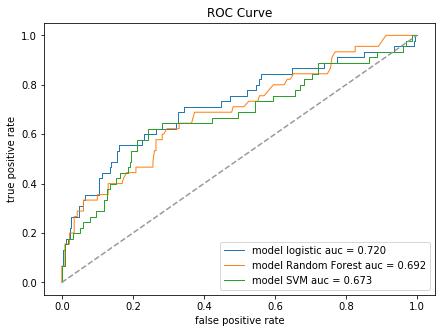

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(7, 5))

for key, value in {'logistic': pred_y_lr2, 'Random Forest': pred_y_rf, 'SVM': pred_y_svm}.items():
    fpr, tpr, thresholds = roc_curve(test_y, value, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='model %s auc = %.3f' % (key, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

从ROC曲线图上可以看到，3个模型的性能比较接近，通过`auc`比较，`logistics回归`的`auc`最高，并且达到了我们预期的0.7，因此，我们将选用`logistics回归`作为我们最终的模型。

### 最终产出模型

最后，我们将所有的数据用于训练，产出最终的模型，并且保存成文件的形式

In [14]:
final_x = preprocessor.preprocess_data(x)

sm = SMOTE()
final_x_sm, y_sm = sm.fit_resample(final_x, y)

lr = LogisticRegression(C=gs_lr2.best_params_['C'])
lr.fit(final_x_sm, y_sm)

LogisticRegression(C=0.125, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
import pickle

with open('model/logistics.model', 'wb') as f:
    pickle.dump(lr, f)

## Landing

在这章的`Landing`部分，我们将按照前几小节探索的结果，编写一个数据输入到模型产出的代码片段。

由于我们的代码逐渐增多，在这一章代码中，我们建立两个`package`，分别为`model`和`preprocessor`，分别用于模型和预处理模块。具体代码可以参考`code/chp3`

### 预处理器

预处理器可以参考`预处理数据集`小节中的实现，与第二章的实现基本相同，我们在这里加入保存和读取的方法，用于下一章。具体代码可以参考`code/chp3/preprocessor/preprocessor.py`。

### 模型

在建模类中，我们实现`smote`、`确定最佳的超参数`、`训练模型`和`保存模型`四个方法。具体代码可以参考`code/chp3/model/pfm_model.py`

#### SMOTE

使用SMOTE算法来平衡数据。这里我们依然使用`x`和`y`，而不是赋值给新的变量，这样的做的好处是如果我们不使用`smote`方法，接下来的方法依然可以使用`x`和`y`。

In [16]:
class Modeler:
    ...
    def smote(self):
        """
        使用SMOTE算法来平衡数据
        :return:
        """
        print('using smote.')
        sm = SMOTE()
        self.x, self.y = sm.fit_resample(self.x, self.y)
    ...

#### 确定最佳的超参数

这个方法中，我们主要使用`GridSearchCV`实现交叉验证方法，来确定最终的超参数。

In [17]:
class Modeler:
    ...
    def determine_hyper_params(self):
        """
        确定最佳的超参数
        :return:
        """
        lr = LogisticRegression()
        # 设定候选超参数
        params = [{'C': [2 ** i for i in range(-10, 10)]}]

        # 通过交叉验证的方式搜索最佳参数
        gs_lr = GridSearchCV(
            estimator=lr,
            param_grid=params,
            # 设定10折交叉验证
            cv=10,
            # 选择auc作为，模型评估指标
            scoring='roc_auc')
        gs_lr.fit(self.x, self.y)
        print('best hyper params: {}'.format(gs_lr.best_params_))
        self.best_hyper_params = gs_lr.best_params_
    ...

#### 训练模型

训练模型的方法，我们直接利用确定的最佳的参数训练`logistics回归`模型。

In [18]:
class Modeler:
    ...
    def train_model(self):
        """
        训练模型
        :return:
        """
        if self.best_hyper_params is None:
            # 如果没有交叉验证选取最佳的参数，则默认设置为1.0
            self.best_hyper_params = {'C': 1.0}
            print('using hyper params: {}'.format(self.best_hyper_params))

        self.model = LogisticRegression(C=self.best_hyper_params['C'])
        self.model.fit(self.x, self.y)
        print('training model is done.')      
    ...

#### 保存模型

我们可以使用`pickle`来保存训练完的模型，用于部署。

In [19]:
class Modeler:
    ...
    def save_model(self, file_path):
        """
        保存模型
        :param file_path: 模型保存路径
        :return:
        """
        if self.model is None:
            print('model is not trained!')
            return

        with open(file_path, 'wb') as f:
            print('saving model to file: {}'.format(file_path))
            pickle.dump(self.model, f)

## 小结

本章讨论了在建模过程中一些实践经验。如何选择模型，除了关注模型本身的精度等，也要关注诸如模型的预测时间、建模时长等；选择超参数上，可以使用交叉验证的方法来确定；选择模型评估指标时，应当要结合数据特点和业务背景来选择等。  
在`Landing`小节中，我们则实现了一个用于建模的类。